In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Pump it Up'

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 5.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
import gc; gc.enable()

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tanzania_train_df = pd.read_csv('training_set_values.csv')
tanzania_train_labels_df = pd.read_csv('training_set_labels.csv')
tanzania_test_df = pd.read_csv('test_set_values.csv')
tanzania_submission_df = pd.read_csv('submission_format.csv')

In [ ]:
tanzania_train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
tanzania_train_labels_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [ ]:
train = tanzania_train_df.merge(tanzania_train_labels_df, on='id', how='right')
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [ ]:
tanzania_test_df['status_group'] = 'unknown'

In [ ]:
tanzania_test_df.shape

(14850, 41)

In [ ]:
tanzania_test_df['status_group'].value_counts()

unknown    14850
Name: status_group, dtype: int64

In [ ]:
tanzania_train_set_df = train.append(tanzania_test_df, ignore_index=True, sort=False)

In [ ]:
tanzania_train_set_df.shape

(74250, 41)

In [ ]:
tanzania_train_set_df.isnull()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
74246,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
74247,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
74248,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


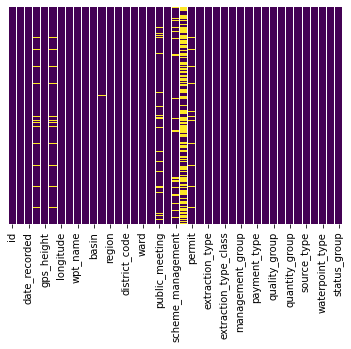

In [ ]:
sns.heatmap(tanzania_train_set_df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
tanzania_train_set_df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [ ]:
tanzania_train_set_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Text(0.5, 1.0, 'Target Histogram')

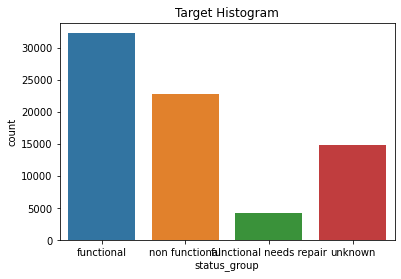

In [ ]:
sns.countplot(x='status_group', data=tanzania_train_set_df)
plt.title('Target Histogram')

In [ ]:
tanzania_train_set_df['water_quality'].value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [ ]:
tanzania_train_set_df['quality_group'].value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

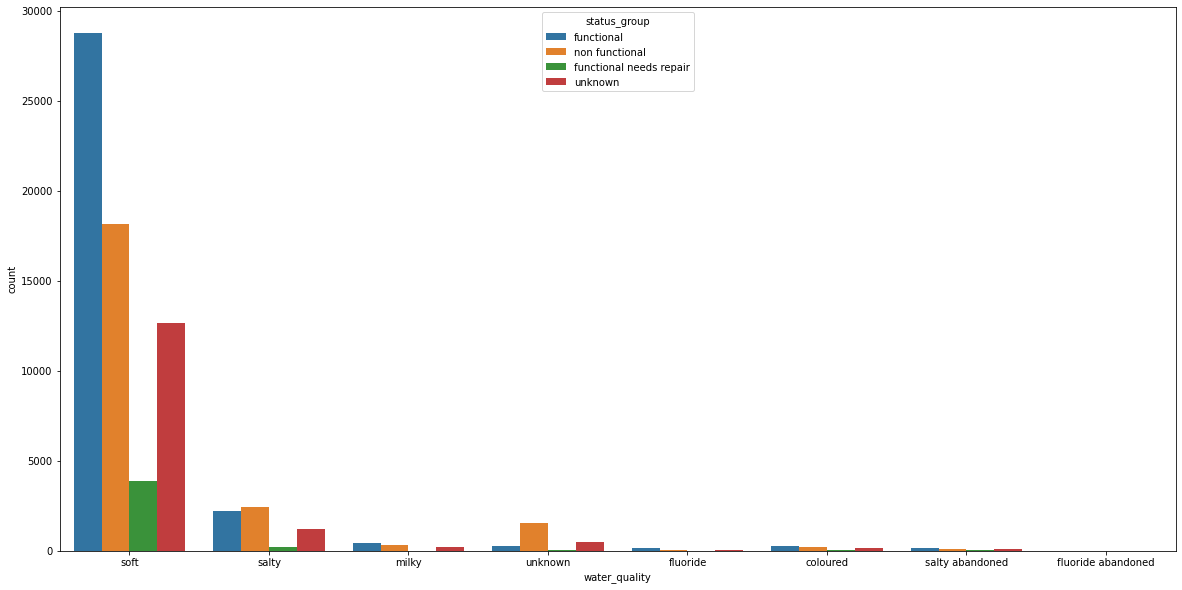

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='water_quality', hue="status_group", data=tanzania_train_set_df)

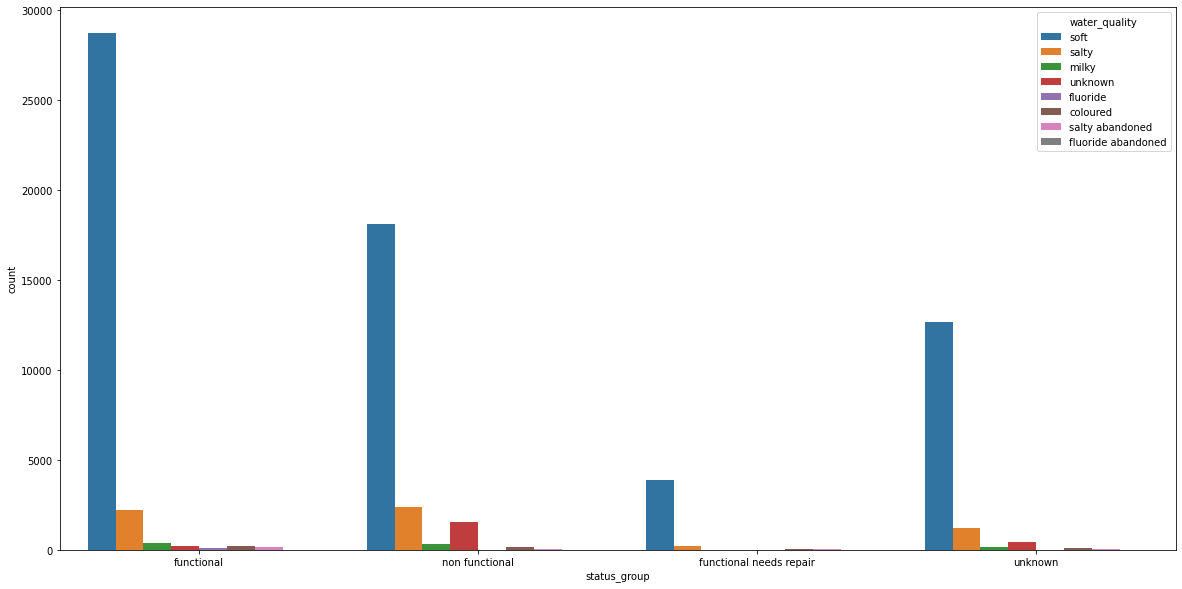

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='status_group', hue="water_quality", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['quantity'].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [ ]:
tanzania_train_set_df['quantity_group'].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

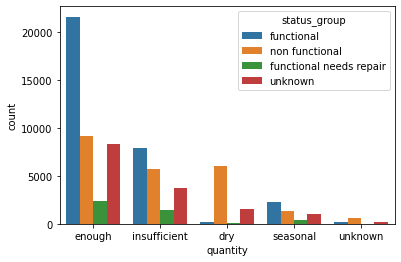

In [ ]:
ax = sns.countplot(x='quantity', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['waterpoint_type'].value_counts()

In [ ]:
tanzania_train_set_df['waterpoint_type_group'].value_counts()

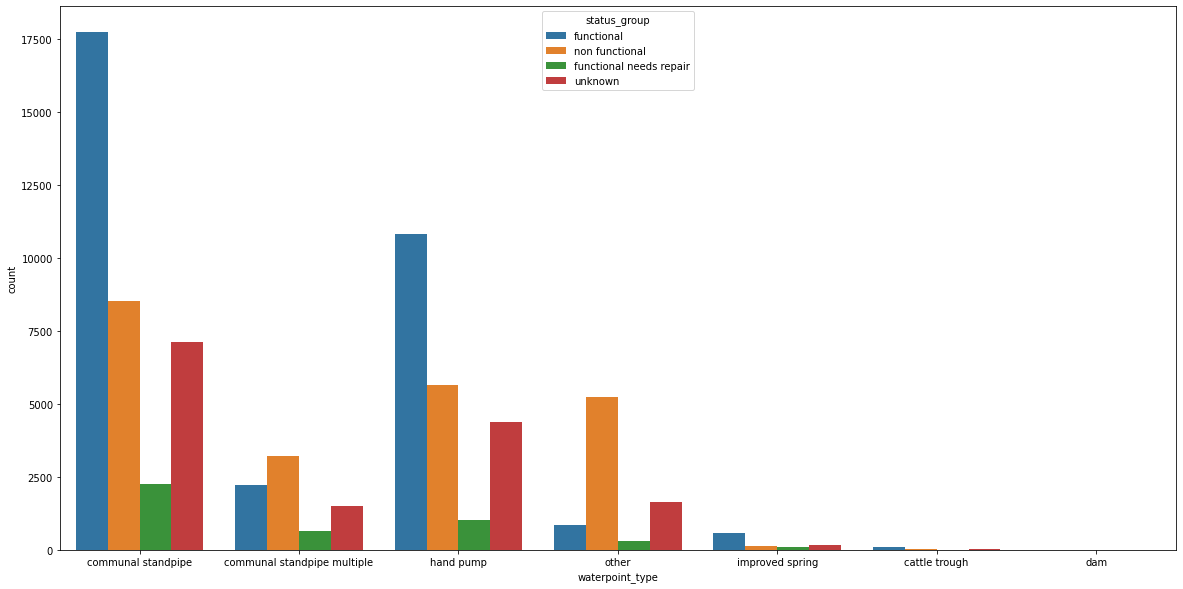

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='waterpoint_type', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['payment'].value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [ ]:
tanzania_train_set_df['payment_type'].value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='payment', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['source'].value_counts()

In [ ]:
tanzania_train_set_df['source_type'].value_counts()

In [ ]:
tanzania_train_set_df['source_class'].value_counts()

In [ ]:
tanzania_train_set_df.groupby(['source_class','source']).count()

In [ ]:
ax = sns.countplot(x='source_class', hue="status_group", data=tanzania_train_set_df)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='source', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['extraction_type'].value_counts()

In [ ]:
tanzania_train_set_df['extraction_type_class'].value_counts()

In [ ]:
tanzania_train_set_df['extraction_type_group'].value_counts()

In [ ]:
tanzania_train_set_df.groupby(['extraction_type_class','extraction_type']).count()

In [ ]:
tanzania_train_set_df.groupby(['extraction_type_class','extraction_type_group']).count()

In [ ]:
tanzania_train_set_df.groupby(['extraction_type_group','extraction_type']).count()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='extraction_type_class', hue="status_group", data=tanzania_train_set_df)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='extraction_type_group', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['scheme_management'].value_counts()

In [ ]:
tanzania_train_set_df['management'].value_counts()

In [ ]:
tanzania_train_set_df['management_group'].value_counts()

In [ ]:
tanzania_train_set_df.groupby(['management_group','management']).count()

In [ ]:
#Dropping simlar columns
tanzania_train_set_df.drop(columns=['quality_group','quantity_group','waterpoint_type_group','payment','source_class','source_type','extraction_type_class','extraction_type','management_group','scheme_management'],inplace=True)

In [ ]:
tanzania_train_set_df.info()

In [ ]:
tanzania_train_set_df['num_private'].value_counts()

In [ ]:
tanzania_train_set_df.drop(columns=['num_private'],inplace=True )

In [ ]:
tanzania_train_set_df['recorded_by'].value_counts()

In [ ]:
tanzania_train_set_df.drop(columns=['recorded_by'],inplace=True )

In [ ]:
tanzania_train_set_df['wpt_name'].value_counts()

In [ ]:
tanzania_train_set_df['scheme_name'].value_counts()

In [ ]:
tanzania_train_set_df.duplicated(subset='id', keep='first').sum()

0

In [ ]:
tanzania_train_set_df.drop(columns=['wpt_name','scheme_name','id'],inplace=True)

In [ ]:
tanzania_train_set_df['amount_tsh'].value_counts()

In [ ]:
tanzania_train_set_df.drop(columns=['amount_tsh'],inplace=True)

In [ ]:
tanzania_train_set_df.info()

In [ ]:
tanzania_train_set_df['region'].value_counts()

In [ ]:
tanzania_train_set_df['region_code'].value_counts()

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='region_code', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df.drop(columns=['region'],inplace=True)

In [ ]:
tanzania_train_set_df.info()

In [ ]:
tanzania_train_set_df['public_meeting'].value_counts()

True     67904
False     6346
Name: public_meeting, dtype: int64

In [ ]:
tanzania_train_set_df['public_meeting'].isnull().sum()

4155

In [ ]:
tanzania_train_set_df['public_meeting'].fillna(value=True,inplace=True)

In [ ]:
tanzania_train_set_df['public_meeting'].isnull().sum()

0

In [ ]:
tanzania_train_set_df['permit'].value_counts()

True     48606
False    21851
Name: permit, dtype: int64

In [ ]:
tanzania_train_set_df['permit'].isnull().sum()

3793

In [ ]:
tanzania_train_set_df['permit'].fillna(value=True,inplace=True)

In [ ]:
tanzania_train_set_df['permit'].isnull().sum()

0

In [ ]:
tanzania_train_set_df['population'].value_counts()

In [ ]:
tanzania_train_set_df.loc[tanzania_train_set_df['population']!=0].describe()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,47416.000000,47416.000000,47416.000000,47416.000000,47416.000000,47416.000000,47416.000000
mean,967.471254,36.078646,-6.140993,16.032710,6.300405,283.042623,1961.912920
std,612.979582,2.587554,2.736761,21.521422,11.327183,564.413842,262.329286
min,-90.000000,29.607122,-11.649440,2.000000,1.000000,1.000000,0.000000
25%,344.000000,34.715217,-8.383484,4.000000,2.000000,40.000000,1986.000000
50%,1133.000000,36.714568,-5.765866,10.000000,3.000000,150.000000,2000.000000
75%,1461.000000,37.949838,-3.600882,16.000000,5.000000,328.000000,2008.000000
max,2777.000000,40.345193,-1.042375,99.000000,67.000000,30500.000000,2013.000000


In [ ]:
tanzania_train_set_df['population'].replace(to_replace = 0 , value =283, inplace=True)

In [ ]:
tanzania_train_set_df['gps_height'].value_counts()

In [ ]:
tanzania_train_set_df.groupby('status_group')[['gps_height']].mean()

In [ ]:
tanzania_train_set_df['longitude'].value_counts()

In [ ]:
tanzania_train_set_df.loc[tanzania_train_set_df['longitude']!=0].describe() 

,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000
mean,686.650616,35.148358,-5.881503,15.185091,5.728248,283.028077,1339.394090
std,693.280413,2.608924,2.808758,17.775842,9.768536,458.088735,938.475708
min,-90.000000,29.607122,-11.649440,1.000000,0.000000,1.000000,0.000000
25%,0.000000,33.277747,-8.632576,5.000000,2.000000,90.000000,0.000000
50%,418.000000,35.007072,-5.173950,12.000000,3.000000,283.000000,1988.000000
75%,1330.000000,37.237383,-3.371872,17.000000,5.000000,283.000000,2005.000000
max,2777.000000,40.345193,-0.998464,99.000000,80.000000,30500.000000,2013.000000


In [ ]:
tanzania_train_set_df['longitude'].replace(to_replace = 0 , value =35.15, inplace=True)

In [ ]:
tanzania_train_set_df['longitude'].value_counts()

In [ ]:
tanzania_train_set_df['latitude'].value_counts()

In [ ]:
tanzania_train_set_df['construction_year'].value_counts()

In [ ]:
tanzania_train_set_df['decade'] = tanzania_train_set_df['construction_year']

In [ ]:
tanzania_train_set_df['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969), value ='60s' , inplace=True)
tanzania_train_set_df['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979), value ='70s' , inplace=True)
tanzania_train_set_df['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989), value ='80s' , inplace=True)
tanzania_train_set_df['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999), value ='90s' , inplace=True)
tanzania_train_set_df['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009), value ='00s' , inplace=True)
tanzania_train_set_df['decade'].replace(to_replace = (2010,2011,2012,2013), value ='10s' , inplace=True)

In [ ]:
tanzania_train_set_df['decade'].value_counts()

0      25969
00s    19163
90s     9611
80s     6939
10s     6461
70s     5448
60s      659
Name: decade, dtype: int64

In [ ]:
tanzania_train_set_df.loc[tanzania_train_set_df['construction_year']!=0].describe()

,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000,48281.000000
mean,1000.202709,35.986840,-6.237147,15.669559,5.967006,281.513370,1996.870943
std,618.538809,2.559941,2.760997,20.937445,10.709279,549.893368,12.440524
min,-63.000000,29.607122,-11.649440,2.000000,1.000000,1.000000,1960.000000
25%,369.000000,34.676387,-8.744394,4.000000,2.000000,40.000000,1988.000000
50%,1153.000000,36.653857,-6.078797,10.000000,3.000000,150.000000,2000.000000
75%,1486.000000,37.814225,-3.654467,16.000000,5.000000,312.000000,2008.000000
max,2777.000000,40.345193,-1.042375,99.000000,63.000000,30500.000000,2013.000000


In [ ]:
tanzania_train_set_df['decade'].replace(to_replace = 0, value = '00s', inplace=True)

In [ ]:
tanzania_train_set_df['decade'].value_counts()

In [ ]:
tanzania_train_set_df.drop(columns=['construction_year'],inplace=True )

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='decade', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['date_recorded'].value_counts()

In [ ]:
tanzania_train_set_df.drop(columns=['date_recorded'],inplace=True )

In [ ]:
tanzania_train_set_df['basin'].value_counts()

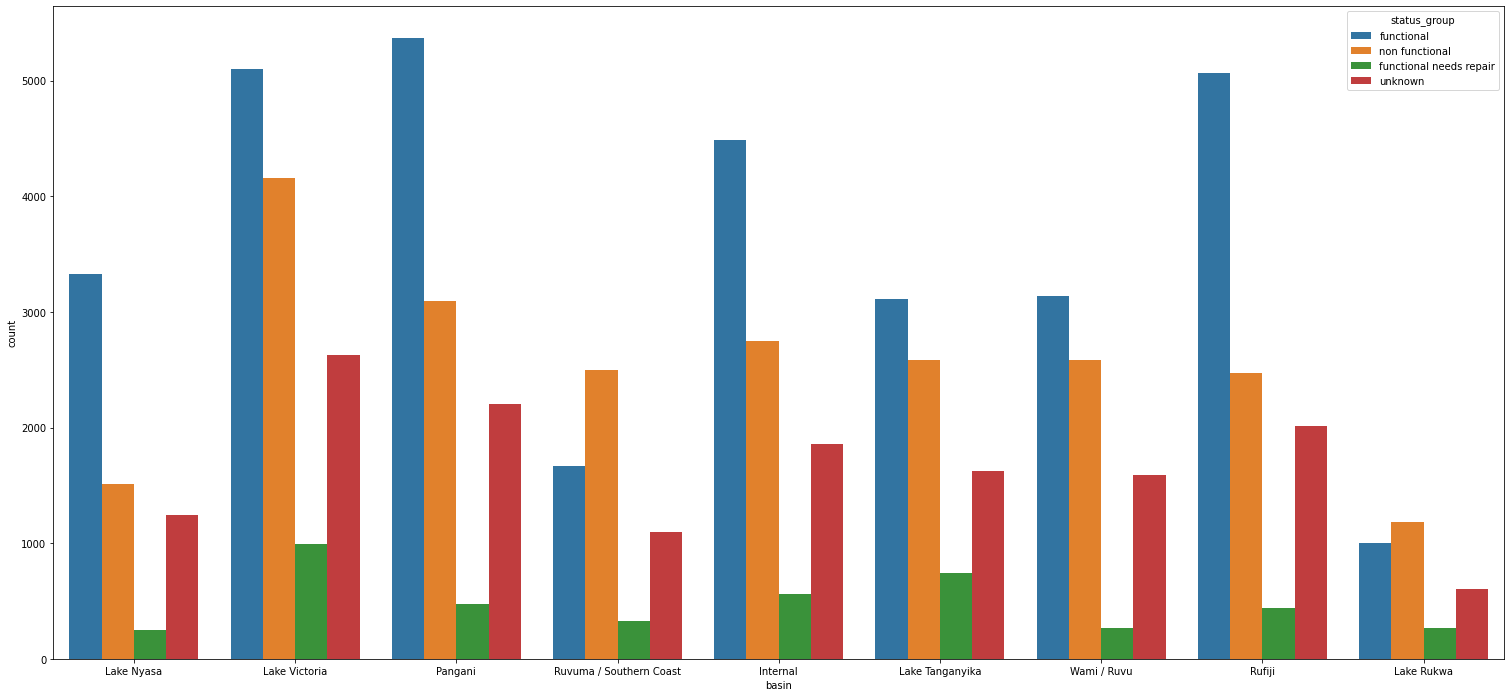

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='basin', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['subvillage'].value_counts()

In [ ]:
tanzania_train_set_df['subvillage'].nunique()

21425

In [ ]:
tanzania_train_set_df.drop(columns=['subvillage'],inplace=True )

In [ ]:
tanzania_train_set_df['district_code'].value_counts()

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='district_code', hue="status_group", data=tanzania_train_set_df)

In [ ]:
tanzania_train_set_df['region_code'].value_counts()

In [ ]:
tanzania_train_set_df['installer'].value_counts()

In [ ]:
tanzania_train_set_df['installer'].fillna(value='Unknown',inplace=True) 

In [ ]:
tanzania_train_set_df['installer'].value_counts().head(50)

In [ ]:
tanzania_train_set_df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) 

In [ ]:
tanzania_train_set_df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'), value ='District water department' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci','District Council','Council','Counc','District  Council','Distri'), value ='District council' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church','RC CATHORIC',) , value ='RC Church' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Central Government','Tanzania Government','central government','Cental Government', 'Cebtral Government','Tanzanian Government','Tanzania government', 'Centra Government','CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr','Centra govt') , value ='Central government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'), value ='world vision' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi','Village Council','Village Counil', 'Villages', 'Vill', 'Village community','Villaers', 'Village Community', 'Villag','Villege Council', 'Village council','Village  Council','Villagerd', 'Villager', 'Village Technician','Village Office','Village community members'), value ='villagers' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY'), value ='Community' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove','Governme','Governmen' ), value ='Government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)

tanzania_train_set_df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

In [ ]:
tanzania_train_set_df['installer'].value_counts().head(50)

In [ ]:
df_1 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'DWE']
df_2 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'Unknown']              
df_3 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'Government'] 
df_4 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'Community'] 
df_5 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'DANIDA'] 
df_6 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'RWE'] 
df_7 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'District council'] 
df_8 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'Central government']
df_9 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'KKKT'] 
df_10 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'HESAWA'] 
df_11 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'TCRS'] 
df_12 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'world vision'] 
df_13 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'CES'] 
df_14 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'Fini Water'] 
df_15 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'RC Church'] 
df_16 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'villagers']
df_17 = tanzania_train_set_df.loc[tanzania_train_set_df['installer']== 'LGA']

installer_df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17], ignore_index=True)

In [ ]:
plt.figure(figsize=(26,10))
ax = sns.countplot(x='installer', hue="status_group", data=installer_df)

In [ ]:
tanzania_train_set_df['categorized_installer'] = tanzania_train_set_df['installer']

In [ ]:
tanzania_train_set_df.loc[~tanzania_train_set_df["categorized_installer"].isin(['DWE','Unknown','Government','Community','DANIDA','RWE','District council', 'Central government','KKKT','HESAWA','TCRS', 'world vision', 'Fini Water', 'RC Church','villagers','LGA']), "categorized_installer"] = "Others"

In [ ]:
tanzania_train_set_df['funder'].value_counts()

In [ ]:
tanzania_train_set_df['funder'].fillna(value='Unknown',inplace=True) 

In [ ]:
tanzania_train_set_df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True) 

In [ ]:
tanzania_train_set_df['funder'].value_counts().head(50)

In [ ]:
df_1 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Government Of Tanzania']
df_2 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Unknown']              
df_3 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Danida'] 
df_4 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Hesawa'] 
df_5 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Rwssp'] 
df_6 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'World Bank'] 
df_7 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Kkkt'] 
df_8 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'World Vision']
df_9 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Unicef'] 
df_10 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Tasaf'] 
df_11 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'District Council'] 
df_12 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Dhv'] 
df_13 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Private Individual'] 
df_14 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Dwsp'] 
df_15 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Norad'] 
df_16 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Germany Republi']
df_17 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Tcrs']
df_18 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Ministry Of Water']
df_19 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Water']
df_20 = tanzania_train_set_df.loc[tanzania_train_set_df['funder']== 'Dwe']

funder_df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17,df_18,df_19,df_20], ignore_index=True)

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='funder', hue="status_group", data=funder_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
tanzania_train_set_df['categorized_funder'] = tanzania_train_set_df['funder'] 

In [ ]:
tanzania_train_set_df.loc[~tanzania_train_set_df["categorized_funder"].isin(['Danida','Unknown','Government Of Tanzania','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision','Unicef','Tasaf','District Council', 'Dhv', 'Private Individual', 'Dwsp','Norad','Germany Republi','Tcrs','Ministry Of Water','Water','Dwe']), "categorized_funder"] = "Others"

In [ ]:
tanzania_train_set_df['categorized_funder'].nunique()

In [ ]:
tanzania_train_set_df.drop(columns=['installer','funder'],inplace=True )

In [ ]:
tanzania_train_set_df['status_group'] = tanzania_train_set_df['status_group'].replace( {'non functional': 0, 'functional': 1, 'functional needs repair': 2, 'unknown':-1})

In [ ]:
tanzania_train_set_df['status_group'].value_counts()

 1    32259
 0    22824
-1    14850
 2     4317
Name: status_group, dtype: int64

In [ ]:
tanzania_train_set_df

.......................................................................Modeling.......................................................................

In [ ]:
train_set_df = tanzania_train_set_df.copy()

In [ ]:
train_set_df.drop(columns=['lga','ward'],inplace=True )

In [ ]:
tanzania_test_df.drop(columns=['lga','ward'],inplace=True )

In [ ]:
train_set_df['permit'] = train_set_df['permit'].astype(bool).astype(int)

In [ ]:
train_set_df['public_meeting'] = train_set_df['public_meeting'].astype(bool).astype(int)

In [ ]:
train_set_df

**One-hot encoding**

In [ ]:
categorical_col = ['basin','extraction_type_group','management','payment_type','water_quality','quantity','source','waterpoint_type','decade','categorized_installer','categorized_funder']

In [ ]:
numerical_col = ['gps_height','longitude','latitude','region_code','district_code','population','public_meeting','permit']

In [ ]:
train_set_df = pd.get_dummies(train_set_df, prefix_sep="_", columns=categorical_col, drop_first=True)

In [ ]:
train_set_df.head(4)

,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,status_group,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,...,decade_60s,decade_70s,decade_80s,decade_90s,categorized_installer_Community,categorized_installer_DANIDA,categorized_installer_DWE,categorized_installer_District council,categorized_installer_Fini Water,categorized_installer_Government,categorized_installer_HESAWA,categorized_installer_KKKT,categorized_installer_LGA,categorized_installer_Others,categorized_installer_RC Church,categorized_installer_RWE,categorized_installer_TCRS,categorized_installer_Unknown,categorized_installer_villagers,categorized_installer_world vision,categorized_funder_Dhv,categorized_funder_District Council,categorized_funder_Dwe,categorized_funder_Dwsp,categorized_funder_Germany Republi,categorized_funder_Government Of Tanzania,categorized_funder_Hesawa,categorized_funder_Kkkt,categorized_funder_Ministry Of Water,categorized_funder_Norad,categorized_funder_Others,categorized_funder_Private Individual,categorized_funder_Rwssp,categorized_funder_Tasaf,categorized_funder_Tcrs,categorized_funder_Unicef,categorized_funder_Unknown,categorized_funder_Water,categorized_funder_World Bank,categorized_funder_World Vision
0,1390,34.938093,-9.856322,11,5,109,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1399,34.698766,-2.147466,20,2,280,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,686,37.460664,-3.821329,21,4,250,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,263,38.486161,-11.155298,90,63,58,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
train_set_df.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 113 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   gps_height                                   74250 non-null  int64  
 1   longitude                                    74250 non-null  float64
 2   latitude                                     74250 non-null  float64
 3   region_code                                  74250 non-null  int64  
 4   district_code                                74250 non-null  int64  
 5   population                                   74250 non-null  int64  
 6   public_meeting                               74250 non-null  int64  
 7   permit                                       74250 non-null  int64  
 8   status_group                                 74250 non-null  int64  
 9   basin_Lake Nyasa                             74250 non-null  uint8  
 1

In [ ]:
train1 = train_set_df.loc[(train_set_df['status_group'] != -1)]
test1 = train_set_df.loc[(train_set_df['status_group'] == -1)]
del test1['status_group']

In [ ]:
train_set = train1.copy()
train_set.drop(columns=['status_group'],inplace=True )

In [ ]:
X_independent = train_set
Y_dependent = train1['status_group']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_independent, Y_dependent, test_size=0.2, random_state=0)

**Feature Selection**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            criterion= 'entropy',max_features= 'sqrt',
                             min_samples_split= 10,class_weight='balanced')

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Feature ranking:
1. feature 1 (0.127492)
2. feature 2 (0.125612)
3. feature 0 (0.066286)
4. feature 5 (0.047623)
5. feature 4 (0.039886)
6. feature 3 (0.036215)
7. feature 52 (0.034924)
8. feature 53 (0.024212)
9. feature 21 (0.021771)
10. feature 70 (0.018631)
11. feature 40 (0.016974)
12. feature 16 (0.016933)
13. feature 7 (0.013288)
14. feature 34 (0.013038)
15. feature 102 (0.012999)
16. feature 65 (0.012242)
17. feature 78 (0.011853)
18. feature 85 (0.011757)
19. feature 44 (0.011590)
20. feature 63 (0.010928)
21. feature 61 (0.010576)
22. feature 54 (0.010479)
23. feature 39 (0.010377)
24. feature 68 (0.010002)
25. feature 43 (0.009322)
26. feature 97 (0.009060)
27. feature 66 (0.008773)
28. feature 75 (0.008729)
29. feature 62 (0.008232)
30. feature 71 (0.008170)
31. feature 6 (0.008057)
32. feature 50 (0.008003)
33. feature 20 (0.007864)
34. feature 58 (0.007561)
35. feature 73 (0.007371)
36. feature 74 (0.007232)
37. feature 11 (0.006948)
38. feature 51 (0.006659)
39. feature

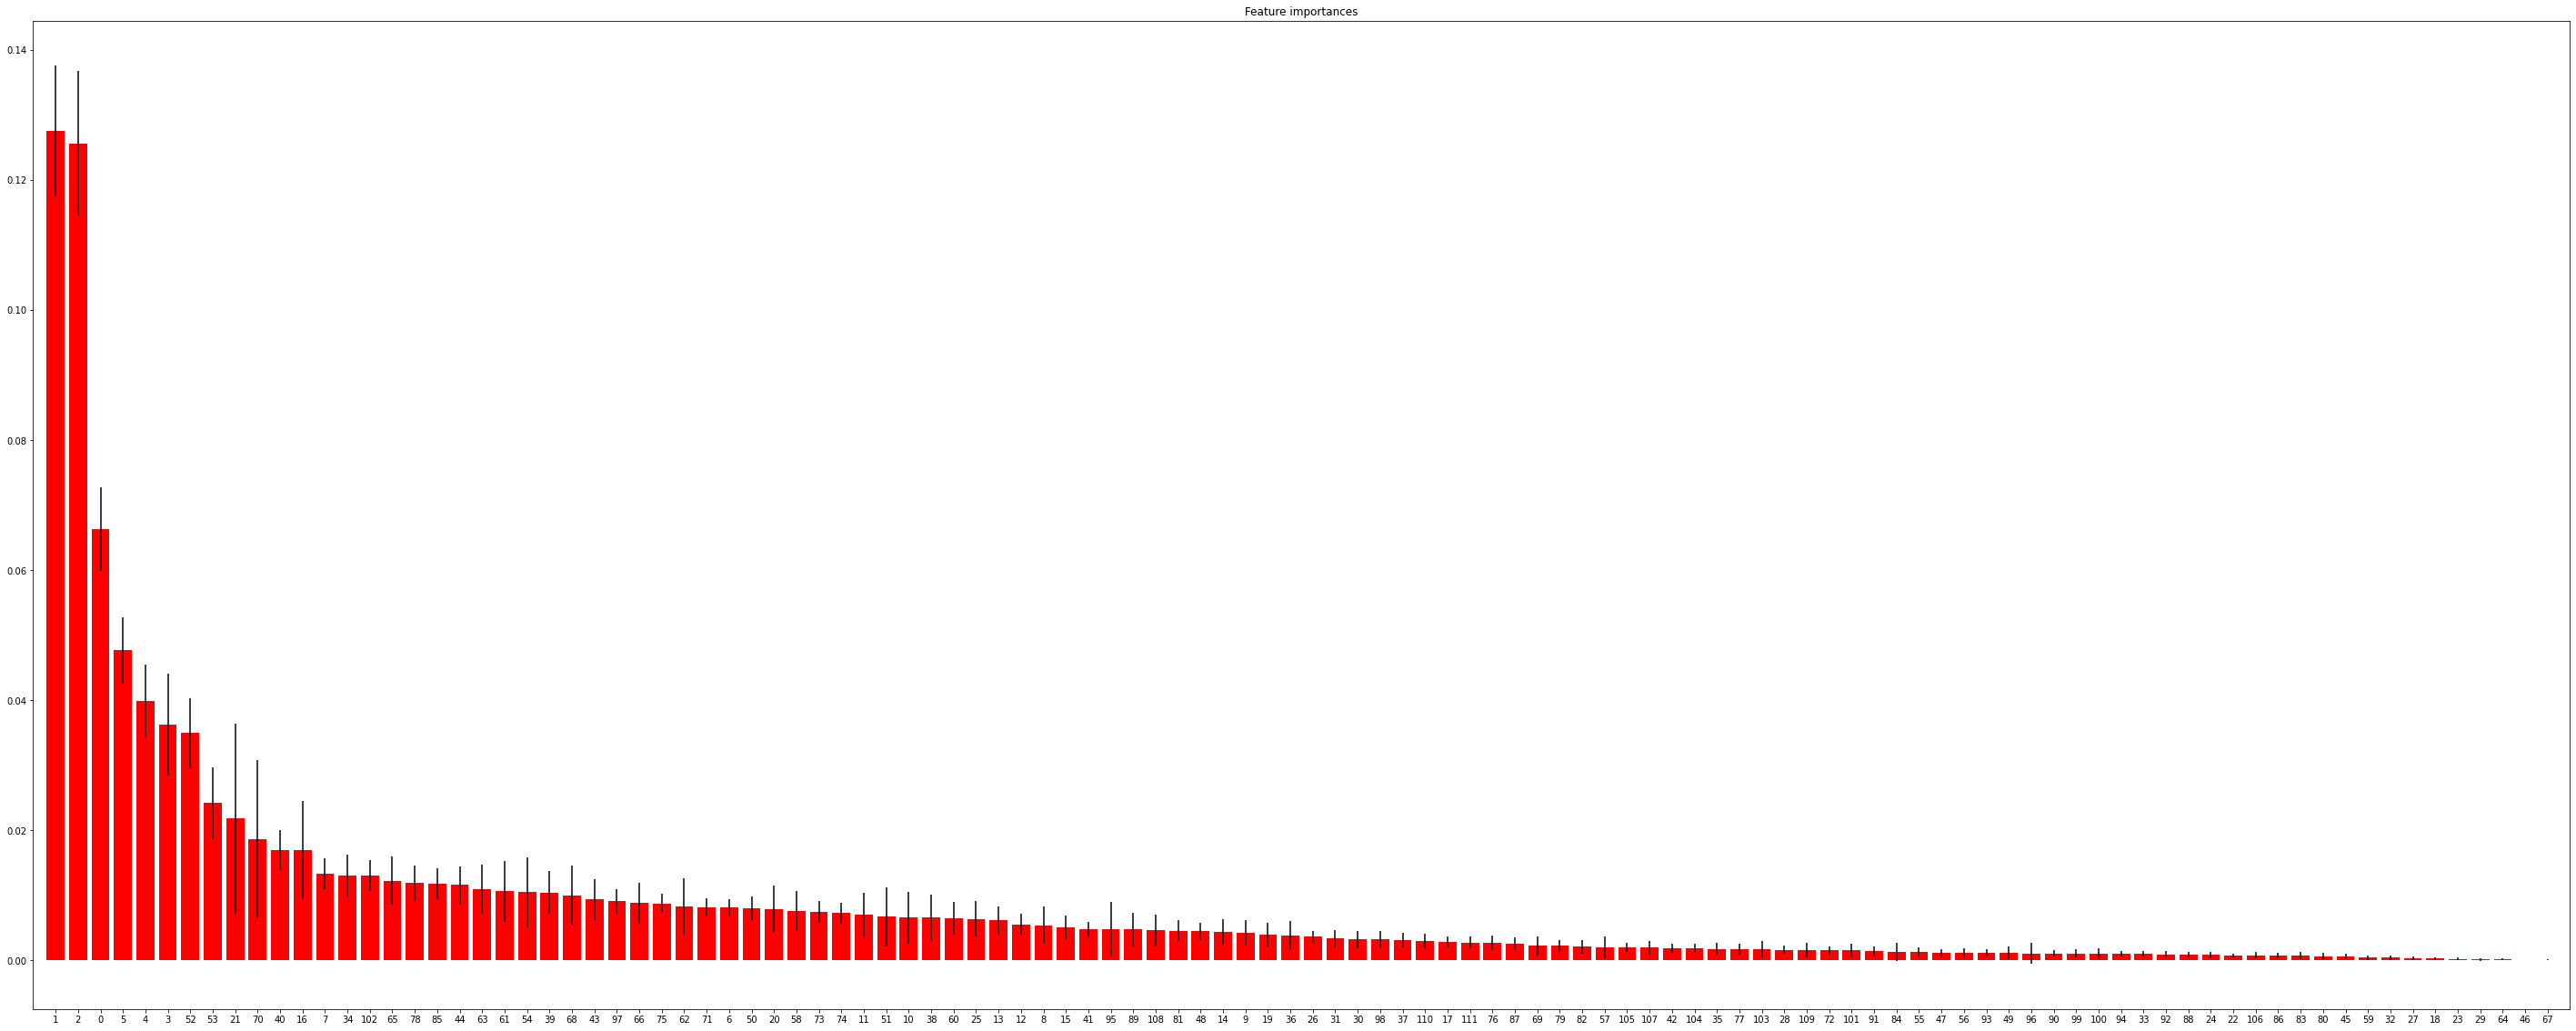

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_independent.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure(figsize=(50,20))
plt.title("Feature importances")
plt.bar(range(X_independent.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_independent.shape[1]), indices)
plt.xlim([-1, X_independent.shape[1]])
plt.show()

In [ ]:
train_sample = train_set_df.copy()
train_sample.drop(columns=(numerical_col),inplace=True)
train_sample.drop(columns=['status_group'],inplace=True)
train_sample

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,...,decade_60s,decade_70s,decade_80s,decade_90s,categorized_installer_Community,categorized_installer_DANIDA,categorized_installer_DWE,categorized_installer_District council,categorized_installer_Fini Water,categorized_installer_Government,categorized_installer_HESAWA,categorized_installer_KKKT,categorized_installer_LGA,categorized_installer_Others,categorized_installer_RC Church,categorized_installer_RWE,categorized_installer_TCRS,categorized_installer_Unknown,categorized_installer_villagers,categorized_installer_world vision,categorized_funder_Dhv,categorized_funder_District Council,categorized_funder_Dwe,categorized_funder_Dwsp,categorized_funder_Germany Republi,categorized_funder_Government Of Tanzania,categorized_funder_Hesawa,categorized_funder_Kkkt,categorized_funder_Ministry Of Water,categorized_funder_Norad,categorized_funder_Others,categorized_funder_Private Individual,categorized_funder_Rwssp,categorized_funder_Tasaf,categorized_funder_Tcrs,categorized_funder_Unicef,categorized_funder_Unknown,categorized_funder_Water,categorized_funder_World Bank,categorized_funder_World Vision
0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74246,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
74247,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
74248,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
cat_col = train_sample.columns

**Random Forest**

In [ ]:
scaler=RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
numerical_transformer = make_pipeline(scaler)
categorical_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', numerical_transformer, numerical_col),
                    ('cat', categorical_transformer, cat_col)])

# set rf with best grid search results

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                            criterion= 'entropy',max_features= 'sqrt',
                             min_samples_split= 10,class_weight='balanced')

#giving all values to pipeline

pipe = make_pipeline(preprocessor,rf)


pipe.fit(X_train,y_train)
# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


Accuracy:
TRAIN: 0.9059974747474747
TEST: 0.7875420875420875

Balanced Accuracy:
TRAIN: 0.9192429609215651
TEST: 0.7105066317753647


In [ ]:
# predictions on test set
y_pred_test = pipe.predict(test1)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")

Accuracy:
TRAIN: 0.9059974747474747

Balanced Accuracy:
TRAIN: 0.9192429609215651


**LGBM**

Accuracy:
TRAIN: 0.7891203703703704
TEST: 0.7816498316498316

Balanced Accuracy:
TRAIN: 0.6169691479118546
TEST: 0.6090436110911052


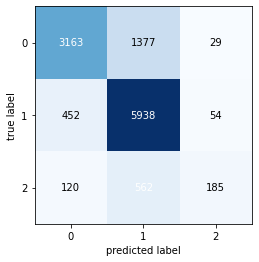

In [ ]:
#seting model
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False,eta = .1,max_depth = 10, 
                      colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)

scaler=RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
numerical_transformer = make_pipeline(scaler)
categorical_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', numerical_transformer, numerical_col),
                    ('cat', categorical_transformer, cat_col)])

#sending everthing in pipe
pipe = make_pipeline(preprocessor,lgbm)
pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
# predictions on test set
y_pred_test = pipe.predict(test1)

print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")

Accuracy:
TRAIN: 0.7891203703703704

Balanced Accuracy:
TRAIN: 0.6169691479118546


**XGBoost**

Accuracy:
TRAIN: 0.8459385521885522
TEST: 0.8005050505050505

Balanced Accuracy:
TRAIN: 0.6841357028515933
TEST: 0.6256339716857503


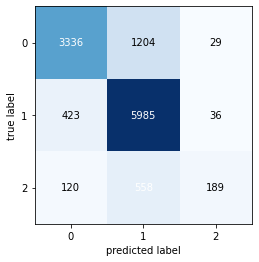

In [ ]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 10, colsample_bytree = .4, n_jobs = -1,learning_rate = 0.05)

pipe = make_pipeline(preprocessor,xgb)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
# make predictions on test set
y_pred_test = pipe.predict(test1)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")

Accuracy:
TRAIN: 0.8459385521885522

Balanced Accuracy:
TRAIN: 0.6841357028515933


**SMOTE**

In [ ]:
df_for_smote = train_set_df.copy()

In [ ]:
# encoding categorical columns
encoder = TargetEncoder()

for c in cat_col:
    df_for_smote[str(c) + '_encoded'] = encoder.fit_transform(df_for_smote[c].values, df_for_smote['status_group'])
    df_for_smote.drop(columns=c, inplace=True) 

In [ ]:
# scaling numerical columns
scaler = preprocessing.RobustScaler()

def scaleColumns(df, numerical_col):
    for col in numerical_col:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df_for_smote[col])),columns=[col])
    return df

scaled_df = scaleColumns(df_for_smote,[numerical_col])

In [ ]:
scaled_df

,gps_height,longitude,latitude,region_code,district_code,population,public_meeting,permit,status_group,basin_Lake Nyasa_encoded,basin_Lake Rukwa_encoded,basin_Lake Tanganyika_encoded,basin_Lake Victoria_encoded,basin_Pangani_encoded,basin_Rufiji_encoded,basin_Ruvuma / Southern Coast_encoded,basin_Wami / Ruvu_encoded,extraction_type_group_gravity_encoded,extraction_type_group_india mark ii_encoded,extraction_type_group_india mark iii_encoded,extraction_type_group_mono_encoded,extraction_type_group_nira/tanira_encoded,extraction_type_group_other_encoded,extraction_type_group_other handpump_encoded,extraction_type_group_other motorpump_encoded,extraction_type_group_rope pump_encoded,extraction_type_group_submersible_encoded,extraction_type_group_swn 80_encoded,extraction_type_group_wind-powered_encoded,management_other_encoded,management_other - school_encoded,management_parastatal_encoded,management_private operator_encoded,management_trust_encoded,management_unknown_encoded,management_vwc_encoded,management_water authority_encoded,management_water board_encoded,management_wua_encoded,management_wug_encoded,...,decade_60s_encoded,decade_70s_encoded,decade_80s_encoded,decade_90s_encoded,categorized_installer_Community_encoded,categorized_installer_DANIDA_encoded,categorized_installer_DWE_encoded,categorized_installer_District council_encoded,categorized_installer_Fini Water_encoded,categorized_installer_Government_encoded,categorized_installer_HESAWA_encoded,categorized_installer_KKKT_encoded,categorized_installer_LGA_encoded,categorized_installer_Others_encoded,categorized_installer_RC Church_encoded,categorized_installer_RWE_encoded,categorized_installer_TCRS_encoded,categorized_installer_Unknown_encoded,categorized_installer_villagers_encoded,categorized_installer_world vision_encoded,categorized_funder_Dhv_encoded,categorized_funder_District Council_encoded,categorized_funder_Dwe_encoded,categorized_funder_Dwsp_encoded,categorized_funder_Germany Republi_encoded,categorized_funder_Government Of Tanzania_encoded,categorized_funder_Hesawa_encoded,categorized_funder_Kkkt_encoded,categorized_funder_Ministry Of Water_encoded,categorized_funder_Norad_encoded,categorized_funder_Others_encoded,categorized_funder_Private Individual_encoded,categorized_funder_Rwssp_encoded,categorized_funder_Tasaf_encoded,categorized_funder_Tcrs_encoded,categorized_funder_Unicef_encoded,categorized_funder_Unknown_encoded,categorized_funder_Water_encoded,categorized_funder_World Bank_encoded,categorized_funder_World Vision_encoded
0,0.779043,-0.055297,-0.928694,-0.083333,0.666667,-0.950820,0.0,-1.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.785877,-0.117749,0.553602,0.666667,-0.333333,-0.016393,0.0,0.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.244495,0.602967,0.231744,0.750000,0.333333,-0.180328,0.0,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,-0.076689,0.870570,-1.178467,6.500000,20.000000,-1.229508,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.276386,-1.048796,0.615539,0.500000,-0.666667,0.000000,0.0,0.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,-0.250569,0.966210,-0.299253,-0.500000,-0

In [ ]:
train1 = scaled_df.loc[(scaled_df['status_group'] != -1)]
test1 = scaled_df.loc[(scaled_df['status_group'] == -1)]
del test1['status_group']

In [ ]:
train_set = train1.copy()
train_set.drop(columns=['status_group'],inplace=True )

In [ ]:
X = train_set
y = train1['status_group']

In [ ]:
# making over-sampling 

smt = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_sampled, y_sample = smt.fit_sample(X, y)

print(y.value_counts())

y_sampled = pd.Series(y_sample) # converting from array to np.series to see value_counts

print(y_sampled.value_counts())

1    32259
0    22824
2     4317
Name: status_group, dtype: int64
2    32259
1    32259
0    32259
dtype: int64


In [ ]:
#splitting train-test balanced target data
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=0)

In [ ]:
X_test

In [ ]:
# setting classifier
xgb_smote = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1,learning_rate = 0.1,
                      early_stopping_rounds=10)


xgb_smote.fit(X_train, y_train)

# predictions of training set
y_pred = xgb_smote.predict(X_train)

# redictions of test set
y_pred_test = xgb_smote.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")


Accuracy:
TRAIN: 0.9665852933958486
TEST: 0.8615933044017359

Balanced Accuracy:
TRAIN: 0.966578651899498
TEST: 0.8617302658099474


In [ ]:
# predictions of test set
y_pred_test = xgb_smote.predict(test1.values)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")

Accuracy:
TRAIN: 0.9665852933958486

Balanced Accuracy:
TRAIN: 0.966578651899498


In [ ]:
y_pred_test

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
y_pred_test.shape

(14850,)

In [ ]:
results = pd.DataFrame()
results["id"] = tanzania_test_df.id
results["status_group"] = y_pred_test
results["status_group"] = results["status_group"].map({0: 'non functional', 1: 'functional', 2: 'functional needs repair'})
results.to_csv('status_output1.csv', index=False)

**Finding best important features of categorical columns**

In [ ]:
train_set_1 = train_set.copy()
train_set_1.drop(columns=(numerical_col),inplace=True)

In [ ]:
#splitting data as train and test and fitting to model
X_train, X_test, y_train, y_test = train_test_split(X_independent, Y_dependent, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

In [ ]:
# looking importance again using Bryan Arnold's code from random forest lecture
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_independent.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_independent.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_independent.shape[1]), indices)
plt.xlim([-1, X_independent.shape[1]])
plt.show()